In [1]:
# Energy-weighted averages (Sep 03–17 ledgers) for NEOEN + SUNNIC
import pandas as pd
import numpy as np

NEOEN_PATH = "/home/renga/Desktop/neoen_data/renga_work/01_Revamped_Results/NEOEN_combined_ledger_SEP_03_to_17.csv"
SUNNIC_PATH = "/home/renga/Desktop/neoen_data/renga_work/01_Revamped_Results/SUNNIC_combined_ledger_SEP_03_to_17.csv"

ORDER = ["deterministic","p10","p20","p30","p40","p50","p60","p70","p80","p90","str_1"]



In [2]:
def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Parse timestamps (safe even if you don't use them later)
    df["run_time"] = pd.to_datetime(df["run_time"], utc=True, errors="coerce")
    df["target_time"] = pd.to_datetime(df["target_time"], utc=True, errors="coerce")

    # Ensure numeric columns are numeric
    num_cols = [
        "actual_MWh","revenue_EUR","penalty_EUR","net_revenue_EUR",
        "da_price","applied_price_EUR_per_MWh","delta_MWh","forecast_MWh","lead_hours"
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df


def energy_weighted_by_forecast_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    Energy-weighted metrics over production intervals only (actual_MWh > 0).
    - EW_DA_EUR_per_MWh = sum(revenue_EUR) / sum(actual_MWh)
    - EW_penalty_EUR_per_MWh = sum(penalty_EUR) / sum(actual_MWh)
    - EW_mu_EUR_per_MWh = sum(net_revenue_EUR) / sum(actual_MWh)
    """
    prod = df[(df["actual_MWh"] > 0) & np.isfinite(df["actual_MWh"])].copy()

    def _calc(g: pd.DataFrame) -> pd.Series:
        energy = g["actual_MWh"].sum()
        if energy <= 0 or not np.isfinite(energy):
            return pd.Series({
                "n_prod_intervals": len(g),
                "energy_MWh": energy,
                "EW_DA_EUR_per_MWh": np.nan,
                "EW_penalty_EUR_per_MWh": np.nan,
                "EW_mu_EUR_per_MWh": np.nan,
            })
        return pd.Series({
            "n_prod_intervals": len(g),
            "energy_MWh": energy,
            "EW_DA_EUR_per_MWh": g["revenue_EUR"].sum() / energy,
            "EW_penalty_EUR_per_MWh": g["penalty_EUR"].sum() / energy,
            "EW_mu_EUR_per_MWh": g["net_revenue_EUR"].sum() / energy,
        })

    out = prod.groupby("forecast_type", dropna=False).apply(_calc)

    # Optional: order forecast types for nicer display
    out = out.reindex([ft for ft in ORDER if ft in out.index])
    return out

def energy_weighted_overall(df: pd.DataFrame) -> pd.Series:
    """Same as above, but aggregated across all forecast types (production intervals only)."""
    prod = df[(df["actual_MWh"] > 0) & np.isfinite(df["actual_MWh"])].copy()
    energy = prod["actual_MWh"].sum()
    return pd.Series({
        "n_prod_rows": len(prod),
        "energy_MWh": energy,
        "EW_DA_EUR_per_MWh": prod["revenue_EUR"].sum() / energy if energy > 0 else np.nan,
        "EW_penalty_EUR_per_MWh": prod["penalty_EUR"].sum() / energy if energy > 0 else np.nan,
        "EW_mu_EUR_per_MWh": prod["net_revenue_EUR"].sum() / energy if energy > 0 else np.nan,
    })



In [3]:
# --- Load
neoen = load_and_clean(NEOEN_PATH)
sunnic = load_and_clean(SUNNIC_PATH)

# --- Energy-weighted results by forecast type
neoen_ew = energy_weighted_by_forecast_type(neoen)
sunnic_ew = energy_weighted_by_forecast_type(sunnic)

print("NEOEN — Energy-weighted metrics by forecast_type")
display(neoen_ew)

print("\nSUNNIC — Energy-weighted metrics by forecast_type")
display(sunnic_ew)

# --- Optional: overall (single number per site)
print("\nOverall (across all forecast types):")
display(pd.DataFrame({
    "NEOEN": energy_weighted_overall(neoen),
    "SUNNIC": energy_weighted_overall(sunnic),
}))


NEOEN — Energy-weighted metrics by forecast_type


/tmp/ipykernel_15678/326845504.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = prod.groupby("forecast_type", dropna=False).apply(_calc)
/tmp/ipykernel_15678/326845504.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = prod.groupby("forecast_type", dropna=False).apply(_calc)


,n_prod_intervals,energy_MWh,EW_DA_EUR_per_MWh,EW_penalty_EUR_per_MWh,EW_mu_EUR_per_MWh
forecast_type,,,,,
deterministic,666.0,809.066423,20.102359,-6.696342,13.401408
p10,666.0,809.066423,20.102359,-9.718031,10.355776
p20,666.0,809.066423,20.102359,-8.557444,11.540306
p30,666.0,809.066423,20.102359,-7.785536,12.312214
p40,666.0,809.066423,20.102359,-7.188502,12.909249
p50,666.0,809.066423,20.102359,-6.643471,13.454279
p60,666.0,809.066423,20.102359,-6.232346,13.865405
p70,666.0,809.066423,20.102359,-6.115125,13.982625
p80,666.0,809.066423,20.102359,-5.794563,14.303187



SUNNIC — Energy-weighted metrics by forecast_type


,n_prod_intervals,energy_MWh,EW_DA_EUR_per_MWh,EW_penalty_EUR_per_MWh,EW_mu_EUR_per_MWh
forecast_type,,,,,
deterministic,781.0,3867.12093,38.851209,0.226395,39.077603
p10,781.0,3867.12093,38.851209,6.976065,45.827274
p20,781.0,3867.12093,38.851209,4.022549,42.873757
p30,781.0,3867.12093,38.851209,1.742327,40.593535
p40,781.0,3867.12093,38.851209,0.280403,39.131612
p50,781.0,3867.12093,38.851209,-0.771984,38.079224
p60,781.0,3867.12093,38.851209,-1.696920,37.154289
p70,781.0,3867.12093,38.851209,-2.583359,36.267850
p80,781.0,3867.12093,38.851209,-3.301280,35.549929



Overall (across all forecast types):


,NEOEN,SUNNIC
n_prod_rows,7326.000000,8591.000000
energy_MWh,8899.730656,42538.330230
EW_DA_EUR_per_MWh,20.102359,38.851209
EW_penalty_EUR_per_MWh,-6.696631,0.267753
EW_mu_EUR_per_MWh,13.398943,39.118962


In [4]:
import pandas as pd
import numpy as np

NEOEN_PATH  = "NEOEN_combined_ledger_SEP_03_to_17.csv"
SUNNIC_PATH = "SUNNIC_combined_ledger_SEP_03_to_17.csv"

ORDER = ["deterministic","p10","p20","p30","p40","p50","p60","p70","p80","p90","str_1"]

def load_ledger(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # times (optional but useful)
    df["run_time"] = pd.to_datetime(df["run_time"], utc=True, errors="coerce")
    df["target_time"] = pd.to_datetime(df["target_time"], utc=True, errors="coerce")

    # numeric columns we use
    num_cols = [
        "actual_MWh","forecast_MWh","delta_MWh",
        "da_price","applied_price_EUR_per_MWh",
    ]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

neoen  = load_ledger(NEOEN_PATH)
sunnic = load_ledger(SUNNIC_PATH)


In [5]:
def add_alt_settlement(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    # Treat applied_price_EUR_per_MWh as the imbalance price used for settling deviations
    imbalance_price = d["applied_price_EUR_per_MWh"]

    # Strategy settlement
    d["da_sched_revenue_EUR"] = d["forecast_MWh"] * d["da_price"]
    d["imbalance_settlement_EUR"] = d["delta_MWh"] * imbalance_price
    d["net_alt_EUR"] = d["da_sched_revenue_EUR"] + d["imbalance_settlement_EUR"]

    # Per-MWh versions (avoid divide-by-zero)
    d["mu_alt_EUR_per_MWh"] = np.where(d["actual_MWh"] > 0, d["net_alt_EUR"] / d["actual_MWh"], np.nan)

    return d

def summarize_by_forecast_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a table per forecast_type:
    - Total net_alt_EUR
    - Energy-weighted net_alt per produced MWh = sum(net_alt_EUR)/sum(actual_MWh)
    - (also DA scheduled component and deviation component per MWh)
    """
    d = df.copy()

    # Use only valid production rows for "per MWh produced" metrics
    prod = d[(d["actual_MWh"] > 0) & np.isfinite(d["actual_MWh"])].copy()

    def _agg(g: pd.DataFrame) -> pd.Series:
        E = g["actual_MWh"].sum()
        return pd.Series({
            "n_prod_rows": len(g),
            "energy_MWh": E,
            "total_net_alt_EUR": g["net_alt_EUR"].sum(),

            # energy-weighted (ratio-of-totals)
            "EW_mu_alt_EUR_per_MWh": g["net_alt_EUR"].sum() / E,
            "EW_DA_sched_EUR_per_MWh": g["da_sched_revenue_EUR"].sum() / E,
            "EW_imbalance_settlement_EUR_per_MWh": g["imbalance_settlement_EUR"].sum() / E,
        })

    out = prod.groupby("forecast_type", dropna=False).apply(_agg)

    # Nice ordering
    out = out.reindex([ft for ft in ORDER if ft in out.index])

    # Rank (higher is better)
    out["rank_by_total_net_alt_EUR"] = out["total_net_alt_EUR"].rank(ascending=False, method="min")
    out["rank_by_EW_mu_alt"] = out["EW_mu_alt_EUR_per_MWh"].rank(ascending=False, method="min")

    return out.sort_values("rank_by_EW_mu_alt")

# --- Run for both sites
neoen_alt  = add_alt_settlement(neoen)
sunnic_alt = add_alt_settlement(sunnic)

neoen_table  = summarize_by_forecast_type(neoen_alt)
sunnic_table = summarize_by_forecast_type(sunnic_alt)

print("NEOEN — ranking by energy-weighted net (EW_mu_alt)")
display(neoen_table)

print("\nSUNNIC — ranking by energy-weighted net (EW_mu_alt)")
display(sunnic_table)

print("\nTop forecast type by EW_mu_alt:")
print("NEOEN :", neoen_table["EW_mu_alt_EUR_per_MWh"].idxmax())
print("SUNNIC:", sunnic_table["EW_mu_alt_EUR_per_MWh"].idxmax())


NEOEN — ranking by energy-weighted net (EW_mu_alt)


/tmp/ipykernel_15678/2886516991.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = prod.groupby("forecast_type", dropna=False).apply(_agg)
/tmp/ipykernel_15678/2886516991.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = prod.groupby("forecast_type", dropna=False).apply(_agg)


,n_prod_rows,energy_MWh,total_net_alt_EUR,EW_mu_alt_EUR_per_MWh,EW_DA_sched_EUR_per_MWh,EW_imbalance_settlement_EUR_per_MWh,rank_by_total_net_alt_EUR,rank_by_EW_mu_alt
forecast_type,,,,,,,,
p90,666.0,809.066423,12764.755993,15.777142,34.883909,-19.106767,1.0,1.0
str_1,666.0,809.066423,12529.831211,15.486777,24.883349,-9.396572,2.0,2.0
p80,666.0,809.066423,11572.228523,14.303187,29.649501,-15.346314,3.0,3.0
p70,666.0,809.066423,11312.872310,13.982625,26.689682,-12.707057,4.0,4.0
p60,666.0,809.066423,11218.033253,13.865405,24.560655,-10.695250,5.0,5.0
p50,666.0,809.066423,10885.405502,13.454279,22.686870,-9.232591,6.0,6.0
deterministic,666.0,809.066423,10842.629455,13.401408,22.551682,-9.150274,7.0,7.0
p40,666.0,809.066423,10444.439649,12.909249,20.734241,-7.824993,8.0,8.0
p30,666.0,809.066423,9961.398856,12.312214,18.743904,-6.431691,9.0,9.0



SUNNIC — ranking by energy-weighted net (EW_mu_alt)


,n_prod_rows,energy_MWh,total_net_alt_EUR,EW_mu_alt_EUR_per_MWh,EW_DA_sched_EUR_per_MWh,EW_imbalance_settlement_EUR_per_MWh,rank_by_total_net_alt_EUR,rank_by_EW_mu_alt
forecast_type,,,,,,,,
p10,781.0,3867.12093,177219.609426,45.827274,14.447416,31.379858,1.0,1.0
p20,781.0,3867.12093,165798.003447,42.873757,22.829160,20.044597,2.0,2.0
str_1,781.0,3867.12093,159245.987604,41.179469,27.810577,13.368892,3.0,3.0
p30,781.0,3867.12093,156980.109034,40.593535,28.816974,11.776561,4.0,4.0
p40,781.0,3867.12093,151326.674338,39.131612,33.384703,5.746909,5.0,5.0
deterministic,781.0,3867.12093,151117.818265,39.077603,37.034113,2.043490,6.0,6.0
p50,781.0,3867.12093,147256.964393,38.079224,37.709417,0.369807,7.0,7.0
p60,781.0,3867.12093,143680.127513,37.154289,41.987261,-4.832973,8.0,8.0
p70,781.0,3867.12093,140252.161201,36.267850,46.181112,-9.913262,9.0,9.0



Top forecast type by EW_mu_alt:
NEOEN : p90
SUNNIC: p10


In [7]:
def add_da_plus_imbalance_settlement(df: pd.DataFrame) -> pd.DataFrame:
    """
    Settlement model:
      DA scheduled revenue        = forecast_MWh * da_price
      Imbalance settlement (signed)= deviation_MWh * imbalance_price
      Net (alt)                   = DA_scheduled + imbalance_settlement

    Also adds explicit deviation volume metrics.
    """
    d = df.copy()

    # deviation volume (recompute; keep your delta_MWh if you prefer)
    d["deviation_MWh"] = d["actual_MWh"] - d["forecast_MWh"]
    d["abs_deviation_MWh"] = d["deviation_MWh"].abs()

    # Prices
    d["imbalance_price_EUR_per_MWh"] = d["applied_price_EUR_per_MWh"]  # rename for clarity

    # Revenue components
    d["da_sched_revenue_EUR"] = d["forecast_MWh"] * d["da_price"]
    d["imbalance_settlement_EUR"] = d["deviation_MWh"] * d["imbalance_price_EUR_per_MWh"]

    # Net under this settlement
    d["net_alt_EUR"] = d["da_sched_revenue_EUR"] + d["imbalance_settlement_EUR"]

    # Per-MWh produced (only meaningful when actual>0)
    d["mu_alt_EUR_per_MWh"] = np.where(d["actual_MWh"] > 0, d["net_alt_EUR"] / d["actual_MWh"], np.nan)

    return d

neoen  = add_da_plus_imbalance_settlement(load_ledger(NEOEN_PATH))
sunnic = add_da_plus_imbalance_settlement(load_ledger(SUNNIC_PATH))


In [8]:
def summarize_forecast_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Produces a table per forecast_type including:
      - total net_alt (EUR)
      - energy-weighted net_alt per produced MWh (EUR/MWh)
      - explicit deviation volume metrics (MWh and normalized)
    """
    prod = df[(df["actual_MWh"] > 0) & np.isfinite(df["actual_MWh"])].copy()

    def _agg(g: pd.DataFrame) -> pd.Series:
        E_prod = g["actual_MWh"].sum()
        E_fcst = g["forecast_MWh"].sum()
        dev_abs = g["abs_deviation_MWh"].sum()

        # Guard against division by 0
        ew_mu_alt = g["net_alt_EUR"].sum() / E_prod if E_prod > 0 else np.nan
        abs_dev_per_prod = dev_abs / E_prod if E_prod > 0 else np.nan
        abs_dev_per_fcst = dev_abs / E_fcst if E_fcst > 0 else np.nan
        net_per_abs_dev = g["net_alt_EUR"].sum() / dev_abs if dev_abs > 0 else np.nan

        return pd.Series({
            "n_prod_rows": len(g),
            "energy_produced_MWh": E_prod,
            "energy_forecast_MWh": E_fcst,

            # revenue under your settlement assumption
            "total_net_alt_EUR": g["net_alt_EUR"].sum(),
            "EW_mu_alt_EUR_per_MWhProduced": ew_mu_alt,

            # components (helpful for debugging/interpretation)
            "EW_DA_sched_EUR_per_MWhProduced": g["da_sched_revenue_EUR"].sum() / E_prod if E_prod > 0 else np.nan,
            "EW_imbalance_settle_EUR_per_MWhProduced": g["imbalance_settlement_EUR"].sum() / E_prod if E_prod > 0 else np.nan,

            # deviation volume metrics (this is what you asked to “include as well”)
            "total_abs_deviation_MWh": dev_abs,
            "abs_deviation_per_MWhProduced": abs_dev_per_prod,
            "abs_deviation_per_MWhForecast": abs_dev_per_fcst,

            # optional “how much net per MWh of deviation created”
            "net_alt_EUR_per_absDeviationMWh": net_per_abs_dev,
        })

    out = prod.groupby("forecast_type", dropna=False).apply(_agg)

    # order + rank by revenue
    out = out.reindex([ft for ft in ORDER if ft in out.index])
    out["rank_by_EW_mu_alt"] = out["EW_mu_alt_EUR_per_MWhProduced"].rank(ascending=False, method="min")
    out["rank_by_total_net_alt"] = out["total_net_alt_EUR"].rank(ascending=False, method="min")

    # sort: best EW net first
    return out.sort_values("rank_by_EW_mu_alt")

neoen_res  = summarize_forecast_types(neoen)
sunnic_res = summarize_forecast_types(sunnic)

print("NEOEN — best to worst (by EW_mu_alt)")
display(neoen_res)

print("\nSUNNIC — best to worst (by EW_mu_alt)")
display(sunnic_res)

print("\nTop forecast type by EW_mu_alt:")
print("NEOEN :", neoen_res["EW_mu_alt_EUR_per_MWhProduced"].idxmax())
print("SUNNIC:", sunnic_res["EW_mu_alt_EUR_per_MWhProduced"].idxmax())


NEOEN — best to worst (by EW_mu_alt)


/tmp/ipykernel_15678/2466605380.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = prod.groupby("forecast_type", dropna=False).apply(_agg)
/tmp/ipykernel_15678/2466605380.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = prod.groupby("forecast_type", dropna=False).apply(_agg)


,n_prod_rows,energy_produced_MWh,energy_forecast_MWh,total_net_alt_EUR,EW_mu_alt_EUR_per_MWhProduced,EW_DA_sched_EUR_per_MWhProduced,EW_imbalance_settle_EUR_per_MWhProduced,total_abs_deviation_MWh,abs_deviation_per_MWhProduced,abs_deviation_per_MWhForecast,net_alt_EUR_per_absDeviationMWh,rank_by_EW_mu_alt,rank_by_total_net_alt
forecast_type,,,,,,,,,,,,,
p90,666.0,809.066423,1301.501789,12771.905253,15.785979,34.883909,-19.097930,508.176210,0.628102,0.390454,25.132828,1.0,1.0
str_1,666.0,809.066423,925.923766,12536.980471,15.495613,24.883349,-9.387736,284.653282,0.351829,0.307426,44.042986,2.0,2.0
p80,666.0,809.066423,1121.008006,11579.377783,14.312024,29.649501,-15.337477,362.452692,0.447989,0.323327,31.947280,3.0,3.0
p70,666.0,809.066423,1010.315516,11320.021570,13.991461,26.689682,-12.698221,300.318880,0.371192,0.297253,37.693340,4.0,4.0
p60,666.0,809.066423,926.309767,11225.182512,13.874241,24.560655,-10.686414,268.404061,0.331745,0.289756,41.821955,5.0,5.0
p50,666.0,809.066423,854.195174,10892.554762,13.463116,22.686870,-9.223754,255.667083,0.316003,0.299308,42.604447,6.0,6.0
deterministic,666.0,809.066423,860.666801,10849.778715,13.410245,22.551682,-9.141438,232.808449,0.287749,0.270498,46.603887,7.0,7.0
p40,666.0,809.066423,785.684176,10451.588908,12.918085,20.734241,-7.816156,257.723522,0.318544,0.328024,40.553493,8.0,8.0
p30,666.0,809.066423,715.399037,9968.548115,12.321050,18.743904,-6.422854,267.706003,0.330883,0.374205,37.236924,9.0,9.0



SUNNIC — best to worst (by EW_mu_alt)


,n_prod_rows,energy_produced_MWh,energy_forecast_MWh,total_net_alt_EUR,EW_mu_alt_EUR_per_MWhProduced,EW_DA_sched_EUR_per_MWhProduced,EW_imbalance_settle_EUR_per_MWhProduced,total_abs_deviation_MWh,abs_deviation_per_MWhProduced,abs_deviation_per_MWhForecast,net_alt_EUR_per_absDeviationMWh,rank_by_EW_mu_alt,rank_by_total_net_alt
forecast_type,,,,,,,,,,,,,
p10,781.0,3867.12093,1225.466233,177219.609426,45.827274,14.447416,31.379858,2703.445853,0.699085,2.206055,65.553231,1.0,1.0
p20,781.0,3867.12093,2007.871123,165798.003447,42.873757,22.829160,20.044597,2040.976429,0.527777,1.016488,81.234649,2.0,2.0
str_1,781.0,3867.12093,2396.696147,159245.987604,41.179469,27.810577,13.368892,1771.147434,0.458002,0.738995,89.911198,3.0,3.0
p30,781.0,3867.12093,2602.889920,156980.109034,40.593535,28.816974,11.776561,1643.967871,0.425114,0.631593,95.488550,4.0,4.0
p40,781.0,3867.12093,3057.545152,151326.674338,39.131612,33.384703,5.746909,1459.186130,0.377331,0.477241,103.706218,5.0,5.0
deterministic,781.0,3867.12093,3457.066032,151117.818265,39.077603,37.034113,2.043490,1402.502008,0.362673,0.405691,107.748736,6.0,6.0
p50,781.0,3867.12093,3480.522682,147256.964393,38.079224,37.709417,0.369807,1354.832203,0.350346,0.389261,108.690186,7.0,7.0
p60,781.0,3867.12093,3900.045039,143680.127513,37.154289,41.987261,-4.832973,1328.376202,0.343505,0.340605,108.162226,8.0,8.0
p70,781.0,3867.12093,4326.948214,140252.161201,36.267850,46.181112,-9.913262,1390.765971,0.359639,0.321420,100.845264,9.0,9.0



Top forecast type by EW_mu_alt:
NEOEN : p90
SUNNIC: p10


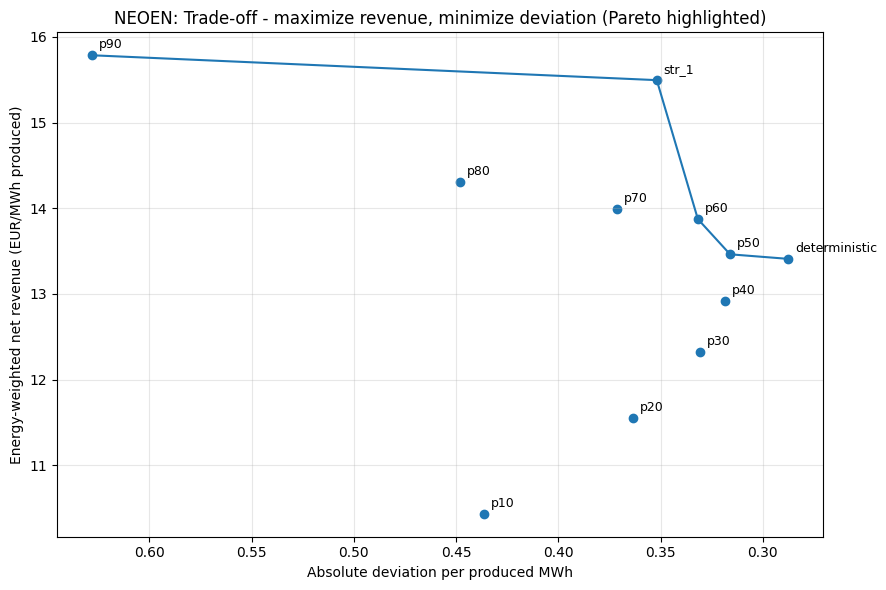

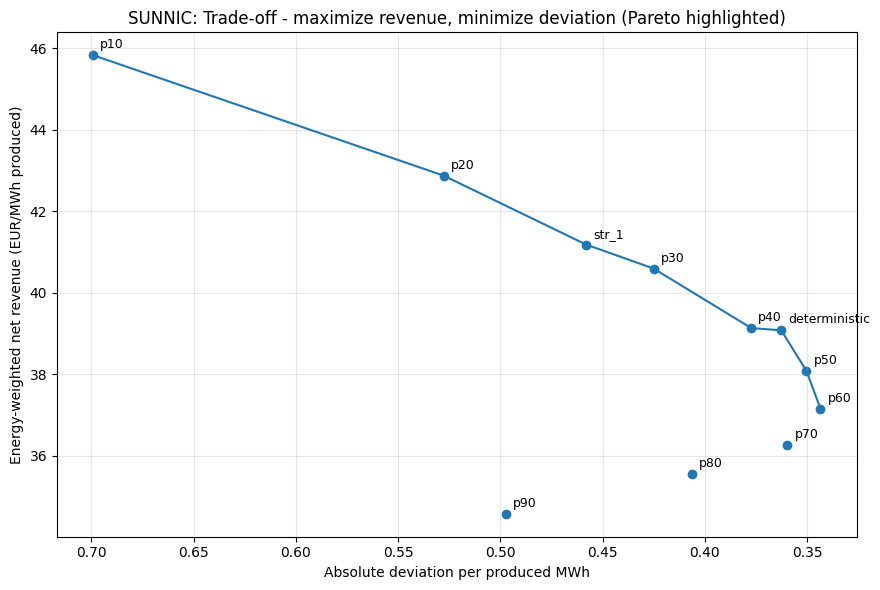

NEOEN Pareto-optimal forecast types: ['deterministic', 'p50', 'p60', 'str_1', 'p90']
SUNNIC Pareto-optimal forecast types: ['p60', 'p50', 'deterministic', 'p40', 'p30', 'str_1', 'p20', 'p10']


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def pareto_front(df, xcol, ycol):
    """
    Returns a boolean mask for Pareto-optimal (non-dominated) points where:
      maximize y, minimize x
    A point i is dominated if there exists j with:
      x_j <= x_i and y_j >= y_i and (x_j < x_i or y_j > y_i)
    """
    x = df[xcol].to_numpy()
    y = df[ycol].to_numpy()
    n = len(df)
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not (np.isfinite(x[i]) and np.isfinite(y[i])):
            is_pareto[i] = False
            continue
        # any j that dominates i?
        dominates = (x <= x[i]) & (y >= y[i]) & ((x < x[i]) | (y > y[i]))
        if np.any(dominates):
            is_pareto[i] = False

    return is_pareto

def plot_tradeoff_pareto(res_df, site_name,
                         xcol="abs_deviation_per_MWhProduced",
                         ycol="EW_mu_alt_EUR_per_MWhProduced"):
    df = res_df[[xcol, ycol]].copy().dropna()
    df = df[np.isfinite(df[xcol]) & np.isfinite(df[ycol])].copy()

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.scatter(df[xcol], df[ycol])

    # label points
    for ft, row in df.iterrows():
        ax.annotate(ft, (row[xcol], row[ycol]), xytext=(5, 5),
                    textcoords="offset points", fontsize=9)

    # Pareto front
    mask = pareto_front(df, xcol, ycol)
    pareto_df = df[mask].sort_values(xcol)  # sort by deviation for a clean line

    # highlight Pareto points (bigger marker)
    ax.scatter(pareto_df[xcol], pareto_df[ycol], s=140, facecolors="none")

    # connect Pareto points (optional, helps the eye)
    ax.plot(pareto_df[xcol], pareto_df[ycol])

    # Make “better” appear up-right: lower deviation to the right, higher revenue up
    ax.invert_xaxis()

    ax.set_title(f"{site_name}: Trade-off - maximize revenue, minimize deviation (Pareto highlighted)")
    ax.set_xlabel("Absolute deviation per produced MWh")
    ax.set_ylabel("Energy-weighted net revenue (EUR/MWh produced)")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pareto_df  # in case you want to print it

neoen_pareto = plot_tradeoff_pareto(neoen_res, "NEOEN")
sunnic_pareto = plot_tradeoff_pareto(sunnic_res, "SUNNIC")

print("NEOEN Pareto-optimal forecast types:", list(neoen_pareto.index))
print("SUNNIC Pareto-optimal forecast types:", list(sunnic_pareto.index))


NEOEN | Best (revenue weight 2.0x deviation): str_1
  EW_mu_alt_EUR_per_MWhProduced: 15.4956
  abs_deviation_per_MWhProduced: 0.3518
  utility_score: 2.5673


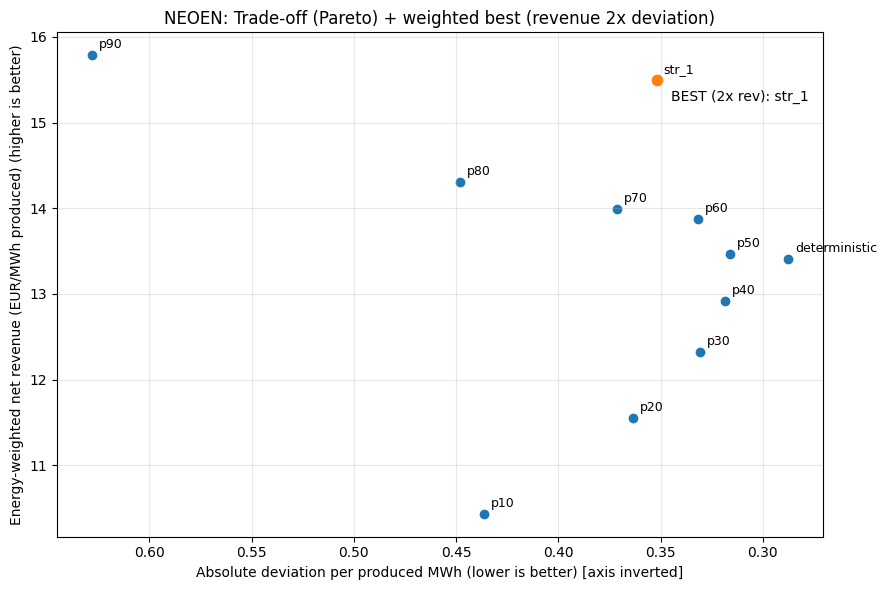

SUNNIC | Best (revenue weight 2.0x deviation): p10
  EW_mu_alt_EUR_per_MWhProduced: 45.8273
  abs_deviation_per_MWhProduced: 0.6991
  utility_score: 2.0000


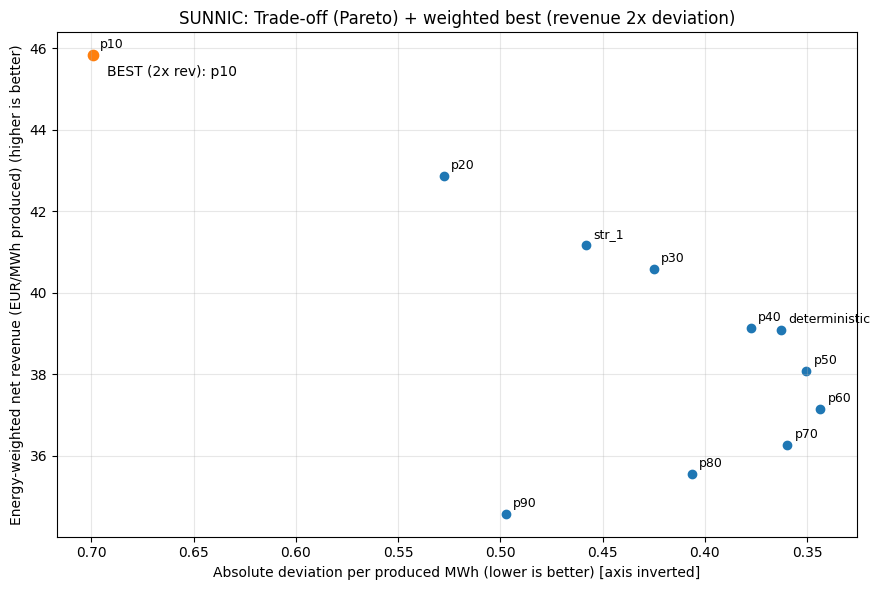

,abs_deviation_per_MWhProduced,EW_mu_alt_EUR_per_MWhProduced,utility_score
forecast_type,,,
str_1,0.351829,15.495613,2.567283
p90,0.628102,15.785979,2.000000
p60,0.331745,13.874241,1.261347
deterministic,0.287749,13.410245,1.000000
p50,0.316003,13.463116,0.961498


,abs_deviation_per_MWhProduced,EW_mu_alt_EUR_per_MWhProduced,utility_score
forecast_type,,,
p10,0.699085,45.827274,2.000000
p20,0.527777,42.873757,1.800687
str_1,0.458002,41.179469,1.606212
p30,0.425114,40.593535,1.563584
deterministic,0.362673,39.077603,1.389612


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Uses your existing summary tables:
# neoen_res, sunnic_res
# Columns expected:
#   xcol = "abs_deviation_per_MWhProduced"  (lower is better)
#   ycol = "EW_mu_alt_EUR_per_MWhProduced"  (higher is better)

def pareto_mask_maxy_minx(df, xcol, ycol):
    x = df[xcol].to_numpy()
    y = df[ycol].to_numpy()
    n = len(df)
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not (np.isfinite(x[i]) and np.isfinite(y[i])):
            is_pareto[i] = False
            continue
        dominates_i = (x <= x[i]) & (y >= y[i]) & ((x < x[i]) | (y > y[i]))
        if np.any(dominates_i):
            is_pareto[i] = False
    return is_pareto

def minmax_norm(arr):
    arr = np.asarray(arr, dtype=float)
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn:
        return np.full_like(arr, 0.5)  # fallback if constant/invalid
    return (arr - mn) / (mx - mn)

def pick_weighted_best(res_df, site_name,
                       xcol="abs_deviation_per_MWhProduced",
                       ycol="EW_mu_alt_EUR_per_MWhProduced",
                       w_revenue=2.0,
                       w_deviation=1.0,
                       restrict_to_pareto=True,
                       plot=True):
    df = res_df[[xcol, ycol]].copy()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = df[np.isfinite(df[xcol]) & np.isfinite(df[ycol])].copy()

    if df.empty:
        raise ValueError(f"{site_name}: no valid rows to score.")

    # Pareto restriction (optional but recommended)
    if restrict_to_pareto:
        mask = pareto_mask_maxy_minx(df, xcol, ycol)
        df_scored = df[mask].copy()
    else:
        df_scored = df.copy()

    # Normalize:
    # - revenue_norm: higher better
    # - deviation_good: lower deviation better => 1 - deviation_norm
    revenue_norm = minmax_norm(df_scored[ycol].values)
    deviation_norm = minmax_norm(df_scored[xcol].values)
    deviation_good = 1.0 - deviation_norm

    # Utility score: revenue twice as important as deviation
    score = w_revenue * revenue_norm + w_deviation * deviation_good
    df_scored["utility_score"] = score

    best_ft = df_scored["utility_score"].idxmax()
    best_row = df_scored.loc[best_ft]

    print(f"{site_name} | Best (revenue weight {w_revenue}x deviation): {best_ft}")
    print(f"  {ycol}: {best_row[ycol]:.4f}")
    print(f"  {xcol}: {best_row[xcol]:.4f}")
    print(f"  utility_score: {best_row['utility_score']:.4f}")

    if plot:
        fig, ax = plt.subplots(figsize=(9, 6))

        # Plot all points (for context)
        ax.scatter(df[xcol], df[ycol])
        for ft, row in df.iterrows():
            ax.annotate(ft, (row[xcol], row[ycol]), xytext=(5, 5),
                        textcoords="offset points", fontsize=9)

        # Highlight Pareto set
        if restrict_to_pareto:
            pareto_df = df[pareto_mask_maxy_minx(df, xcol, ycol)].copy()
            ax.scatter(pareto_df[xcol], pareto_df[ycol], s=140, facecolors="none")

        # Highlight the weighted-best point (bigger marker)
        ax.scatter([best_row[xcol]], [best_row[ycol]], s=220, marker=".")
        ax.annotate(f"BEST (2x rev): {best_ft}", (best_row[xcol], best_row[ycol]),
                    xytext=(10, -15), textcoords="offset points", fontsize=10)

        # Invert x-axis so "better" (lower deviation) appears to the right
        ax.invert_xaxis()

        ax.set_title(f"{site_name}: Trade-off (Pareto) + weighted best (revenue 2x deviation)")
        ax.set_xlabel("Absolute deviation per produced MWh (lower is better) [axis inverted]")
        ax.set_ylabel("Energy-weighted net revenue (EUR/MWh produced) (higher is better)")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return df_scored.sort_values("utility_score", ascending=False)

# Run for both sites (recommended: restrict to Pareto first)
neoen_scored  = pick_weighted_best(neoen_res,  "NEOEN",  w_revenue=2.0, w_deviation=1.0, restrict_to_pareto=True)
sunnic_scored = pick_weighted_best(sunnic_res, "SUNNIC", w_revenue=2.0, w_deviation=1.0, restrict_to_pareto=True)

# If you want to see the top few options:
display(neoen_scored.head(5))
display(sunnic_scored.head(5))


NEOEN | Best (revenue weight 1.5x deviation): str_1
  EW_mu_alt_EUR_per_MWhProduced: 15.4956
  abs_deviation_per_MWhProduced: 0.3518
  utility_score: 2.1284


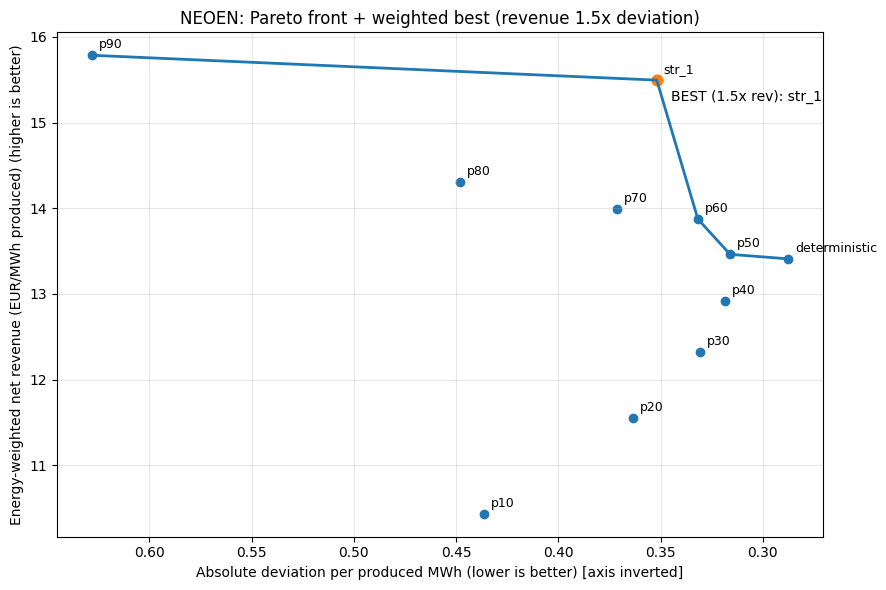

SUNNIC | Best (revenue weight 1.5x deviation): p10
  EW_mu_alt_EUR_per_MWhProduced: 45.8273
  abs_deviation_per_MWhProduced: 0.6991
  utility_score: 1.5000


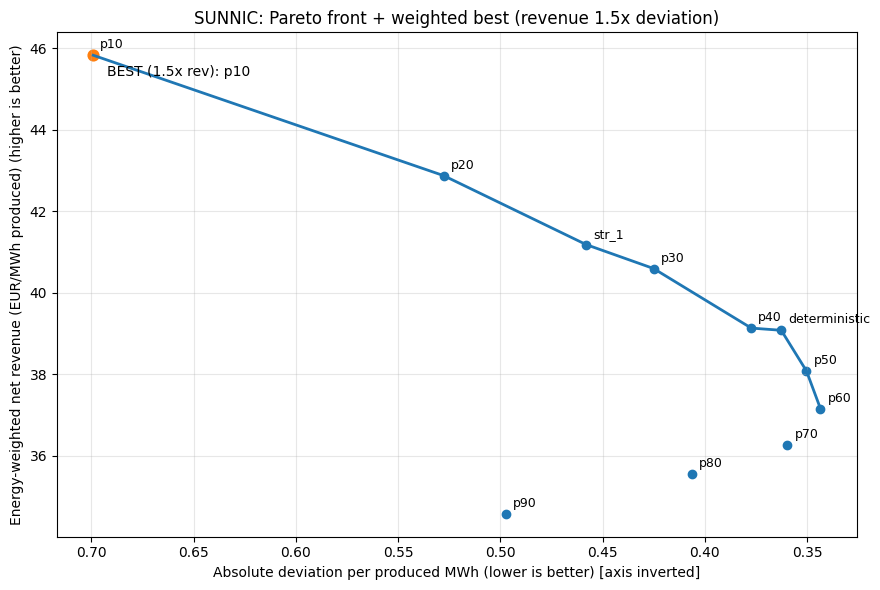

,abs_deviation_per_MWhProduced,EW_mu_alt_EUR_per_MWhProduced,utility_score
forecast_type,,,
str_1,0.351829,15.495613,2.128393
p90,0.628102,15.785979,1.500000
p60,0.331745,13.874241,1.163694
deterministic,0.287749,13.410245,1.000000
p50,0.316003,13.463116,0.950371


,abs_deviation_per_MWhProduced,EW_mu_alt_EUR_per_MWhProduced,utility_score
forecast_type,,,
p10,0.699085,45.827274,1.500000
p20,0.527777,42.873757,1.470958
str_1,0.458002,41.179469,1.374159
p30,0.425114,40.593535,1.365311
deterministic,0.362673,39.077603,1.278732


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def pareto_mask_maxy_minx(df, xcol, ycol):
    x = df[xcol].to_numpy()
    y = df[ycol].to_numpy()
    n = len(df)
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not (np.isfinite(x[i]) and np.isfinite(y[i])):
            is_pareto[i] = False
            continue
        dominates_i = (x <= x[i]) & (y >= y[i]) & ((x < x[i]) | (y > y[i]))
        if np.any(dominates_i):
            is_pareto[i] = False
    return is_pareto

def minmax_norm(arr):
    arr = np.asarray(arr, dtype=float)
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn:
        return np.full_like(arr, 0.5)
    return (arr - mn) / (mx - mn)

def pick_weighted_best_with_pareto_line(res_df, site_name,
                                       xcol="abs_deviation_per_MWhProduced",
                                       ycol="EW_mu_alt_EUR_per_MWhProduced",
                                       w_revenue=1.5,
                                       w_deviation=1.0,
                                       restrict_to_pareto=True,
                                       plot=True):
    df = res_df[[xcol, ycol]].copy()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = df[np.isfinite(df[xcol]) & np.isfinite(df[ycol])].copy()

    if df.empty:
        raise ValueError(f"{site_name}: no valid rows to score.")

    pareto_df = df[pareto_mask_maxy_minx(df, xcol, ycol)].copy()
    pareto_df = pareto_df.sort_values(xcol)  # sort by deviation for a clean line

    # Optionally score only within the Pareto set (recommended)
    df_scored = pareto_df.copy() if restrict_to_pareto else df.copy()

    revenue_norm = minmax_norm(df_scored[ycol].values)
    deviation_good = 1.0 - minmax_norm(df_scored[xcol].values)

    df_scored["utility_score"] = w_revenue * revenue_norm + w_deviation * deviation_good

    best_ft = df_scored["utility_score"].idxmax()
    best_row = df_scored.loc[best_ft]

    print(f"{site_name} | Best (revenue weight {w_revenue}x deviation): {best_ft}")
    print(f"  {ycol}: {best_row[ycol]:.4f}")
    print(f"  {xcol}: {best_row[xcol]:.4f}")
    print(f"  utility_score: {best_row['utility_score']:.4f}")

    if plot:
        fig, ax = plt.subplots(figsize=(9, 6))

        # All points
        ax.scatter(df[xcol], df[ycol])
        for ft, row in df.iterrows():
            ax.annotate(ft, (row[xcol], row[ycol]), xytext=(5, 5),
                        textcoords="offset points", fontsize=9)

        # Pareto points highlight + Pareto line
        ax.scatter(pareto_df[xcol], pareto_df[ycol], s=140, facecolors="none")
        ax.plot(pareto_df[xcol], pareto_df[ycol], linewidth=2)

        # Best (weighted) highlight
        ax.scatter([best_row[xcol]], [best_row[ycol]], s=240, marker=".")
        ax.annotate(f"BEST (1.5x rev): {best_ft}", (best_row[xcol], best_row[ycol]),
                    xytext=(10, -15), textcoords="offset points", fontsize=10)

        # Make “better” (lower deviation) appear to the right
        ax.invert_xaxis()

        ax.set_title(f"{site_name}: Pareto front + weighted best (revenue 1.5x deviation)")
        ax.set_xlabel("Absolute deviation per produced MWh (lower is better) [axis inverted]")
        ax.set_ylabel("Energy-weighted net revenue (EUR/MWh produced) (higher is better)")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return pareto_df, df_scored.sort_values("utility_score", ascending=False)

# Run (requires neoen_res and sunnic_res already computed)
neoen_pareto,  neoen_scored_15  = pick_weighted_best_with_pareto_line(neoen_res,  "NEOEN",  w_revenue=1.5, w_deviation=1.0)
sunnic_pareto, sunnic_scored_15 = pick_weighted_best_with_pareto_line(sunnic_res, "SUNNIC", w_revenue=1.5, w_deviation=1.0)

display(neoen_scored_15.head(5))
display(sunnic_scored_15.head(5))


In [24]:
def corr_decomp_spread(df: pd.DataFrame, min_actual_MWh: float = 0.0) -> pd.DataFrame:
    """
    Uses:
      e  = actual - forecast
      pi = imbalance - DA  (spread)
      P  = e * pi  (incremental deviation cashflow vs DA)
    """
    d = df.copy()

    d["e"]  = d["actual_MWh"] - d["forecast_MWh"]
    d["pi"] = d["applied_price_EUR_per_MWh"] - d["da_price"]   
    d["P"]  = d["e"] * d["pi"]
# Avoid divide-by-zero & meaningless night intervals
    d = d[(d["actual_MWh"] > min_actual_MWh) & np.isfinite(d["e"]) & np.isfinite(d["pi"])].copy()

    def _stats(g: pd.DataFrame) -> pd.Series:
        e  = g["e"].to_numpy()
        pi = g["pi"].to_numpy()

        # moments
        B = np.mean(e)                      # bias
        rmse = np.sqrt(np.mean(e**2))       # RMSE
        mean_pi = np.mean(pi)
        sigma_pi = np.std(pi, ddof=0)

        sigma_e = np.sqrt(max(rmse**2 - B**2, 0.0))  # == std(e) with ddof=0

        # correlation rho(e,pi)
        rho = np.corrcoef(e, pi)[0, 1] if (np.std(e, ddof=0) > 0 and sigma_pi > 0) else np.nan

        # empirical vs decomposed E[e*pi]
        E_emp = np.mean(e * pi)
        E_decomp = sigma_pi * sigma_e * rho + B * mean_pi if np.isfinite(rho) else np.nan

        return pd.Series({
            "n": len(g),
            "bias_B_E[e]_MWh": B,
            "RMSE_e_MWh": rmse,
            "mean_spread_E[pi]_EUR_per_MWh": mean_pi,
            "sigma_spread_sigma_pi": sigma_pi,
            "rho_corr_e_pi": rho,
            "E[e*pi]_empirical_EUR_per_interval": E_emp,
            "E[e*pi]_decomp_EUR_per_interval": E_decomp,
            "decomp_error_emp_minus_decomp": E_emp - E_decomp
        })

    out = d.groupby("forecast_type").apply(_stats)
    out = out.reindex([ft for ft in ORDER if ft in out.index])
    return out

neoen  = load_ledger(NEOEN_PATH)
sunnic = load_ledger(SUNNIC_PATH)

# Set min_actual_MWh to something small (e.g. 0.01) to reduce sunrise/sunset noise
neoen_corr  = corr_decomp_spread(neoen,  min_actual_MWh=0.0)
sunnic_corr = corr_decomp_spread(sunnic, min_actual_MWh=0.0)

print("NEOEN (pi = imbalance - DA):")
display(neoen_corr)

print("SUNNIC (pi = imbalance - DA):")
display(sunnic_corr)

#neoen_corr.to_csv("NEOEN_corr_decomp_spread.csv", index=True)
#sunnic_corr.to_csv("SUNNIC_corr_decomp_spread.csv", index=True)

NEOEN (pi = imbalance - DA):


/tmp/ipykernel_15678/1107809299.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = d.groupby("forecast_type").apply(_stats)
/tmp/ipykernel_15678/1107809299.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = d.groupby("forecast_type").apply(_stats)


,n,bias_B_E[e]_MWh,RMSE_e_MWh,mean_spread_E[pi]_EUR_per_MWh,sigma_spread_sigma_pi,rho_corr_e_pi,E[e*pi]_empirical_EUR_per_interval,E[e*pi]_decomp_EUR_per_interval,decomp_error_emp_minus_decomp
forecast_type,,,,,,,,,
deterministic,666.0,-0.077478,0.578914,3.373348,86.466041,-0.158616,-8.129677,-8.129677,1.776357e-15
p10,666.0,0.428310,0.827144,0.896577,86.611615,-0.197890,-11.744195,-11.744195,-1.776357e-15
p20,666.0,0.256442,0.727860,1.489054,86.751206,-0.182293,-10.390570,-10.390570,5.329071e-15
p30,666.0,0.140642,0.674791,2.031847,86.358594,-0.170870,-9.452846,-9.452846,-1.776357e-15
p40,666.0,0.035108,0.645210,2.501216,86.102459,-0.158916,-8.727559,-8.727559,0.000000e+00
p50,666.0,-0.067761,0.631998,3.012958,86.309826,-0.144953,-8.065448,-8.065448,-1.776357e-15
p60,666.0,-0.176041,0.645627,3.602027,86.089600,-0.129627,-7.566007,-7.566007,0.000000e+00
p70,666.0,-0.302176,0.695813,4.063408,86.087632,-0.114826,-7.423606,-7.423606,-2.664535e-15
p80,666.0,-0.468381,0.799591,4.363934,86.157533,-0.089375,-7.034183,-7.034183,8.881784e-16


SUNNIC (pi = imbalance - DA):


,n,bias_B_E[e]_MWh,RMSE_e_MWh,mean_spread_E[pi]_EUR_per_MWh,sigma_spread_sigma_pi,rho_corr_e_pi,E[e*pi]_empirical_EUR_per_interval,E[e*pi]_decomp_EUR_per_interval,decomp_error_emp_minus_decomp
forecast_type,,,,,,,,,
deterministic,781.0,0.525038,2.603901,18.596044,119.807291,-0.028285,1.120994,1.120994,2.220446e-16
p10,781.0,3.382400,4.916333,18.596044,119.807291,-0.066340,34.541982,34.541982,0.000000e+00
p20,781.0,2.380602,3.828982,18.596044,119.807291,-0.067777,19.917646,19.917646,1.421085e-14
p30,781.0,1.618734,3.210447,18.596044,119.807291,-0.064652,8.627128,8.627128,5.329071e-15
p40,781.0,1.036589,2.904502,18.596044,119.807291,-0.055029,1.388416,1.388416,8.881784e-16
p50,781.0,0.495004,2.715026,18.596044,119.807291,-0.040733,-3.822481,-3.822481,-9.325873e-15
p60,781.0,-0.042156,2.629495,18.596044,119.807291,-0.024186,-8.402297,-8.402297,3.552714e-15
p70,781.0,-0.588767,2.662652,18.596044,119.807291,-0.005923,-12.791499,-12.791499,-3.552714e-15
p80,781.0,-1.209428,2.884465,18.596044,119.807291,0.019584,-16.346285,-16.346285,-3.552714e-15


                     n_prod_intervals  energy_MWh  inc_EUR_total  \
forecast_type site                                                 
deterministic NEOEN               666  809.066423   -5414.364649   
str_1         NEOEN               666  809.066423   -3727.162894   

                     inc_EUR_per_MWhProduced  mean_spread  sigma_spread  \
forecast_type site                                                        
deterministic NEOEN                -6.692114     3.373348     86.466041   
str_1         NEOEN                -4.606745     3.254790     85.864626   

                     bias_E[e]_MWh  RMSE_e_MWh  rho_e_spread  \
forecast_type site                                             
deterministic NEOEN      -0.077478    0.578914     -0.158616   
str_1         NEOEN      -0.175461    0.670375     -0.090456   

                     corr_term_EUR_per_interval  bias_term_EUR_per_interval  \
forecast_type site                                                            
determinist

,inc_EUR_per_MWhProduced,mean_spread,sigma_spread,bias_E[e]_MWh,RMSE_e_MWh,rho_e_spread
site,,,,,,
NEOEN,-6.692114,3.373348,86.466041,-0.077478,0.578914,-0.158616
SUNNIC,0.226395,18.596044,119.807291,0.525038,2.603901,-0.028285



=== str_1: SUNNIC vs NEOEN ===


,inc_EUR_per_MWhProduced,mean_spread,sigma_spread,bias_E[e]_MWh,RMSE_e_MWh,rho_e_spread
site,,,,,,
NEOEN,-4.606745,3.254790,85.864626,-0.175461,0.670375,-0.090456
SUNNIC,2.328261,18.596044,119.807291,1.882746,3.410019,-0.068941


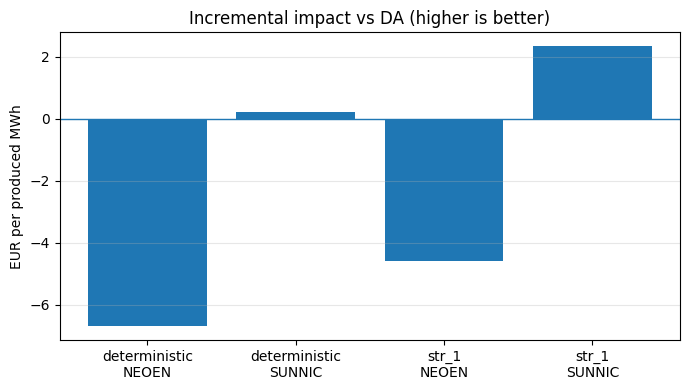

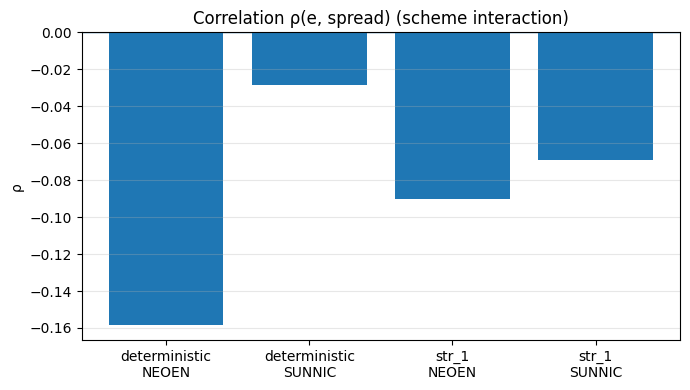

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

NEOEN_PATH  = "NEOEN_combined_ledger_SEP_03_to_17.csv"
SUNNIC_PATH = "SUNNIC_combined_ledger_SEP_03_to_17.csv"

FOCUS = ["deterministic", "str_1"]

def load_ledger(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    for c in ["actual_MWh","forecast_MWh","da_price","applied_price_EUR_per_MWh"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def summarize_site(df: pd.DataFrame, site: str, focus=FOCUS, min_actual_MWh=0.0) -> pd.DataFrame:
    d = df.copy()

    # core terms
    d["e"] = d["actual_MWh"] - d["forecast_MWh"]
    d["spread"] = d["applied_price_EUR_per_MWh"] - d["da_price"]         # imbalance - DA
    d["inc_EUR"] = d["e"] * d["spread"]                                   # incremental EUR vs DA

    # production filter (optional threshold to avoid sunrise/sunset noise)
    d = d[(d["actual_MWh"] > min_actual_MWh) & np.isfinite(d["e"]) & np.isfinite(d["spread"])].copy()
    d = d[d["forecast_type"].isin(focus)].copy()

    rows = []
    for ft, g in d.groupby("forecast_type"):
        E = g["actual_MWh"].sum()
        inc_total = g["inc_EUR"].sum()

        # population moments (ddof=0) for the whiteboard decomposition
        e = g["e"].to_numpy()
        sp = g["spread"].to_numpy()

        B = np.mean(e)
        rmse = np.sqrt(np.mean(e**2))
        mean_sp = np.mean(sp)
        sigma_sp = np.std(sp, ddof=0)
        sigma_e = np.sqrt(max(rmse**2 - B**2, 0.0))  # == std(e) with ddof=0
        rho = np.corrcoef(e, sp)[0,1] if (np.std(e, ddof=0) > 0 and sigma_sp > 0) else np.nan

        corr_term = sigma_sp * sigma_e * rho
        bias_term = B * mean_sp

        rows.append({
            "site": site,
            "forecast_type": ft,
            "n_prod_intervals": len(g),
            "energy_MWh": E,

            # headline KPI you care about
            "inc_EUR_total": inc_total,
            "inc_EUR_per_MWhProduced": inc_total / E if E > 0 else np.nan,

            # scheme drivers
            "mean_spread": mean_sp,
            "sigma_spread": sigma_sp,
            "bias_E[e]_MWh": B,
            "RMSE_e_MWh": rmse,
            "rho_e_spread": rho,
            "corr_term_EUR_per_interval": corr_term,
            "bias_term_EUR_per_interval": bias_term,
            "E[e*spread]_EUR_per_interval": np.mean(e * sp),
        })

    return pd.DataFrame(rows).set_index(["forecast_type","site"]).sort_index()

neo = load_ledger(NEOEN_PATH)
sun = load_ledger(SUNNIC_PATH)

neo_sum = summarize_site(neo, "NEOEN", min_actual_MWh=0.0)
sun_sum = summarize_site(sun, "SUNNIC", min_actual_MWh=0.0)

#print(neo_sum)
#print(sun_sum)

#neo_sum.to_csv("NEOEN_corr_bias_summary.csv", index=True)
#sun_sum.to_csv("SUNNIC_corr_bias_summary.csv", index=True)

comp = pd.concat([neo_sum, sun_sum]).reset_index()

# --- Pretty comparison tables
for ft in FOCUS:
    print(f"\n=== {ft}: SUNNIC vs NEOEN ===")
    display(
        comp[comp["forecast_type"] == ft]
        .set_index("site")
        [[
            "inc_EUR_per_MWhProduced",
            "mean_spread","sigma_spread",
            "bias_E[e]_MWh","RMSE_e_MWh","rho_e_spread"
        ]]
        .sort_index()
    )

# --- Simple plots: (1) headline KPI, (2) rho comparison
def bar_compare(metric, title, ylabel):
    fig, ax = plt.subplots(figsize=(7,4))
    sub = comp[comp["forecast_type"].isin(FOCUS)].copy()

    labels = []
    vals = []
    for ft in FOCUS:
        for site in ["NEOEN","SUNNIC"]:
            labels.append(f"{ft}\n{site}")
            vals.append(sub[(sub["forecast_type"]==ft) & (sub["site"]==site)][metric].iloc[0])

    x = np.arange(len(labels))
    ax.bar(x, vals)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

bar_compare(
    "inc_EUR_per_MWhProduced",
    "Incremental impact vs DA (higher is better)",
    "EUR per produced MWh"
)

bar_compare(
    "rho_e_spread",
    "Correlation ρ(e, spread) (scheme interaction)",
    "ρ"
)


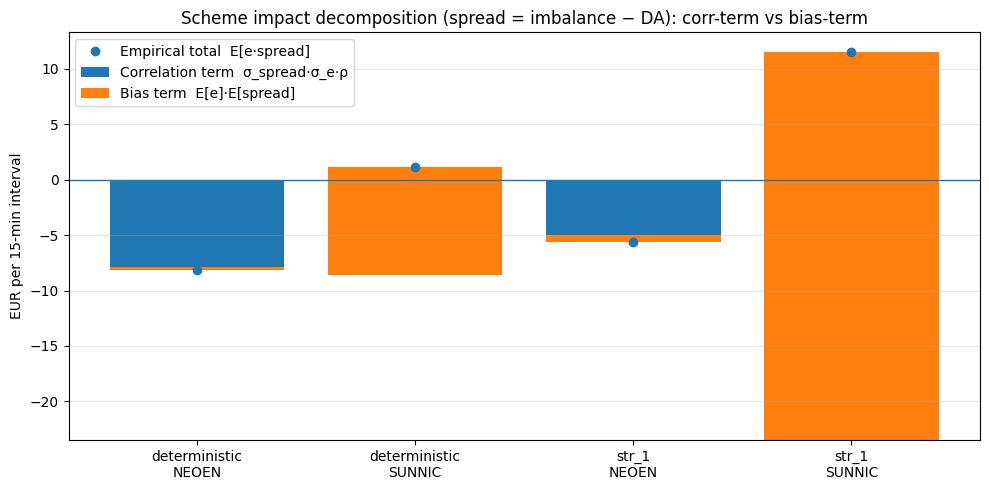

In [26]:
# Decomposition plot (side-by-side across sites, for deterministic & str_1)
# Requires `comp` from the previous comparison cell (the dataframe with both sites + metrics).

import numpy as np
import matplotlib.pyplot as plt

def plot_decomp_terms(comp_df):
    focus = ["deterministic", "str_1"]
    sites = ["NEOEN", "SUNNIC"]

    # Build ordered labels: (det, neo), (det, sun), (str_1, neo), (str_1, sun)
    labels, corr_vals, bias_vals, total_vals = [], [], [], []
    for ft in focus:
        for site in sites:
            row = comp_df[(comp_df["forecast_type"] == ft) & (comp_df["site"] == site)].iloc[0]
            labels.append(f"{ft}\n{site}")
            corr_vals.append(row["corr_term_EUR_per_interval"])
            bias_vals.append(row["bias_term_EUR_per_interval"])
            total_vals.append(row["E[e*spread]_EUR_per_interval"])

    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 5))

    # Stacked bars: corr term + bias term
    ax.bar(x, corr_vals, label="Correlation term  σ_spread·σ_e·ρ")
    ax.bar(x, bias_vals, bottom=corr_vals, label="Bias term  E[e]·E[spread]")

    # Empirical total marker
    ax.plot(x, total_vals, marker="o", linewidth=0, label="Empirical total  E[e·spread]")

    ax.axhline(0, linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("EUR per 15-min interval")
    ax.set_title("Scheme impact decomposition (spread = imbalance − DA): corr-term vs bias-term")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_decomp_terms(comp)
